# Importing the used libraries and reading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import os
import shutil
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation,Conv2D,MaxPooling2D,BatchNormalization,Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
classes = ["Apparel","Footwear"]
def create_dataframe(paths):
    dfs = {}
    for path_name, path in paths.items():
        filepaths = []
        labels = []
        classlist = os.listdir(path)

        for lbl in classlist:
            if lbl == 'Apparel':
                label = 'Apparel'
            elif lbl == 'Footwear':
                label = 'Footwear'
            else:
                continue

            classpath = os.path.join(path, lbl)
            flist = os.listdir(classpath)

            for f in flist:
                fpath = os.path.join(classpath, f)
                filepaths.append(fpath)
                labels.append(label)

        df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
        dfs[path_name] = df

    return dfs

train_path = "/content/drive/MyDrive/Slash/data/train"
test_path = "/content/drive/MyDrive/Slash/data/test"
valid_path = "/content/drive/MyDrive/Slash/data/validation"

paths = {'train': train_path, 'test': test_path, 'valid': valid_path}
dfs = create_dataframe(paths)

# Access the dataframes
train_df = dfs['train']
test_df = dfs['test']
valid_df = dfs['valid']

# Display lengths of dataframes
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))


train_df length: 1815 test_df length: 576 valid_df length: 515


In [5]:
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the train dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

The number of classes in the train dataset is:  2
            CLASS               IMAGE COUNT 
           Apparel                  850     
           Footwear                 965     
Footwear  has the most images=  965   Apparel  has the least images=  850


In [6]:
classes=sorted(list(valid_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the validation dataset is: ', class_count)
groups=valid_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(valid_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

The number of classes in the validation dataset is:  2
            CLASS               IMAGE COUNT 
           Apparel                  210     
           Footwear                 305     
Footwear  has the most images=  305   Apparel  has the least images=  210


In [7]:
classes=sorted(list(test_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the test dataset is: ', class_count)
groups=test_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(test_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

The number of classes in the test dataset is:  2
            CLASS               IMAGE COUNT 
           Apparel                  266     
           Footwear                 310     
Footwear  has the most images=  310   Apparel  has the least images=  266


# Data preprocessing & preparation

In [8]:
def balance(df, n, working_dir, img_size):
    print('Initial length of dataframe is', len(df))
    aug_dir = os.path.join(working_dir, 'aug')  # directory to store the augmented images
    shutil.rmtree(aug_dir, ignore_errors=True)  # Remove existing directory
    os.makedirs(aug_dir)  # Create a new directory

    # Create class directories within the aug directory
    for label in df['labels'].unique():
        os.makedirs(os.path.join(aug_dir, label))

    total = 0
    gen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=.2,
        height_shift_range=.2,
        zoom_range=.2,
        shear_range=0.2
    )

    groups = df.groupby('labels')  # Group by class
    for label, group in groups:
        sample_count = len(group)  # Number of samples in this class
        if sample_count < n:
            delta = n - sample_count  # Number of augmented images to create
            target_dir = os.path.join(aug_dir, label)  # Directory to save the images
            print(f"For class {label}, creating {delta} augmented images.")

            aug_gen = gen.flow_from_dataframe(
                group,
                x_col='filepaths',
                y_col=None,
                target_size=img_size,
                class_mode=None,
                batch_size=1,
                shuffle=False,
                save_to_dir=target_dir,
                save_prefix='aug-',
                color_mode='rgb',
                save_format='jpg'
            )

            aug_img_count = 0
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count

    print('Total Augmented images created =', total)

    # Create aug_df and merge with train_df
    aug_df = pd.DataFrame(columns=['filepaths', 'labels'])
    for root, dirs, files in os.walk(aug_dir):
        for file in files:
            fpath = os.path.join(root, file)
            label = os.path.basename(root)
            aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=True)

    df = pd.concat([df, aug_df]).reset_index(drop=True)
    print('Length of augmented dataframe is now', len(df))
    return df

In [9]:
n = 950
num = 300
m = 250
working_dir = '/content/drive/MyDrive/Slash/folder_of_trails'
img_size = (224, 224)
train_df = balance(train_df, n, working_dir, img_size)
valid_df = balance(valid_df,num,working_dir,img_size)
test_df = balance(test_df,m,working_dir,img_size)

Initial length of dataframe is 1815
For class Apparel, creating 100 augmented images.
Found 850 validated image filenames.
Total Augmented images created = 100
Length of augmented dataframe is now 1915
Initial length of dataframe is 515


<ipython-input-8-de76369984b8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=True)
<ipython-input-8-de76369984b8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=True)
<ipython-input-8-de76369984b8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=True)
<ipython-input-8-de76369984b8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=Tr

For class Apparel, creating 90 augmented images.
Found 210 validated image filenames.
Total Augmented images created = 90
Length of augmented dataframe is now 605
Initial length of dataframe is 576


<ipython-input-8-de76369984b8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=True)
<ipython-input-8-de76369984b8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=True)
<ipython-input-8-de76369984b8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=True)
<ipython-input-8-de76369984b8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=Tr

Total Augmented images created = 0
Length of augmented dataframe is now 576


In [10]:
def setup_data_generators(train_df, valid_df, test_df, img_size, batch_size=20):

        train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=20
        )


        t_and_v_datagen = ImageDataGenerator()


        train_gen = train_datagen.flow_from_dataframe(
            train_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )

        valid_gen = t_and_v_datagen.flow_from_dataframe(
            valid_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )


        length = len(test_df)
        test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
        test_steps = int(length / test_batch_size)

        test_gen = t_and_v_datagen.flow_from_dataframe(
            test_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=False,
            batch_size=test_batch_size
        )


        classes = list(train_gen.class_indices.keys())
        class_indices = list(train_gen.class_indices.values())
        class_count = len(classes)
        labels = test_gen.labels

        print('Test batch size:', test_batch_size, 'Test steps:', test_steps, 'Number of classes:', class_count)

        return train_gen, valid_gen, test_gen

In [11]:
train_gen, valid_gen, test_gen = setup_data_generators(train_df, valid_df, test_df, img_size, batch_size=20)

Found 1815 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 100 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 90 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 576 validated image filenames belonging to 2 classes.
Test batch size: 72 Test steps: 8 Number of classes: 2


In [12]:
def show_image_samples(gen):
    images, labels = next(gen)  # Get a sample batch from the generator
    print("Number of images:", len(images))
    print("Number of labels:", len(labels))

    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # Show a maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        class_name = 'Footwear' if labels[i] == 1 else 'Apparel'
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()



Number of images: 20
Number of labels: 20


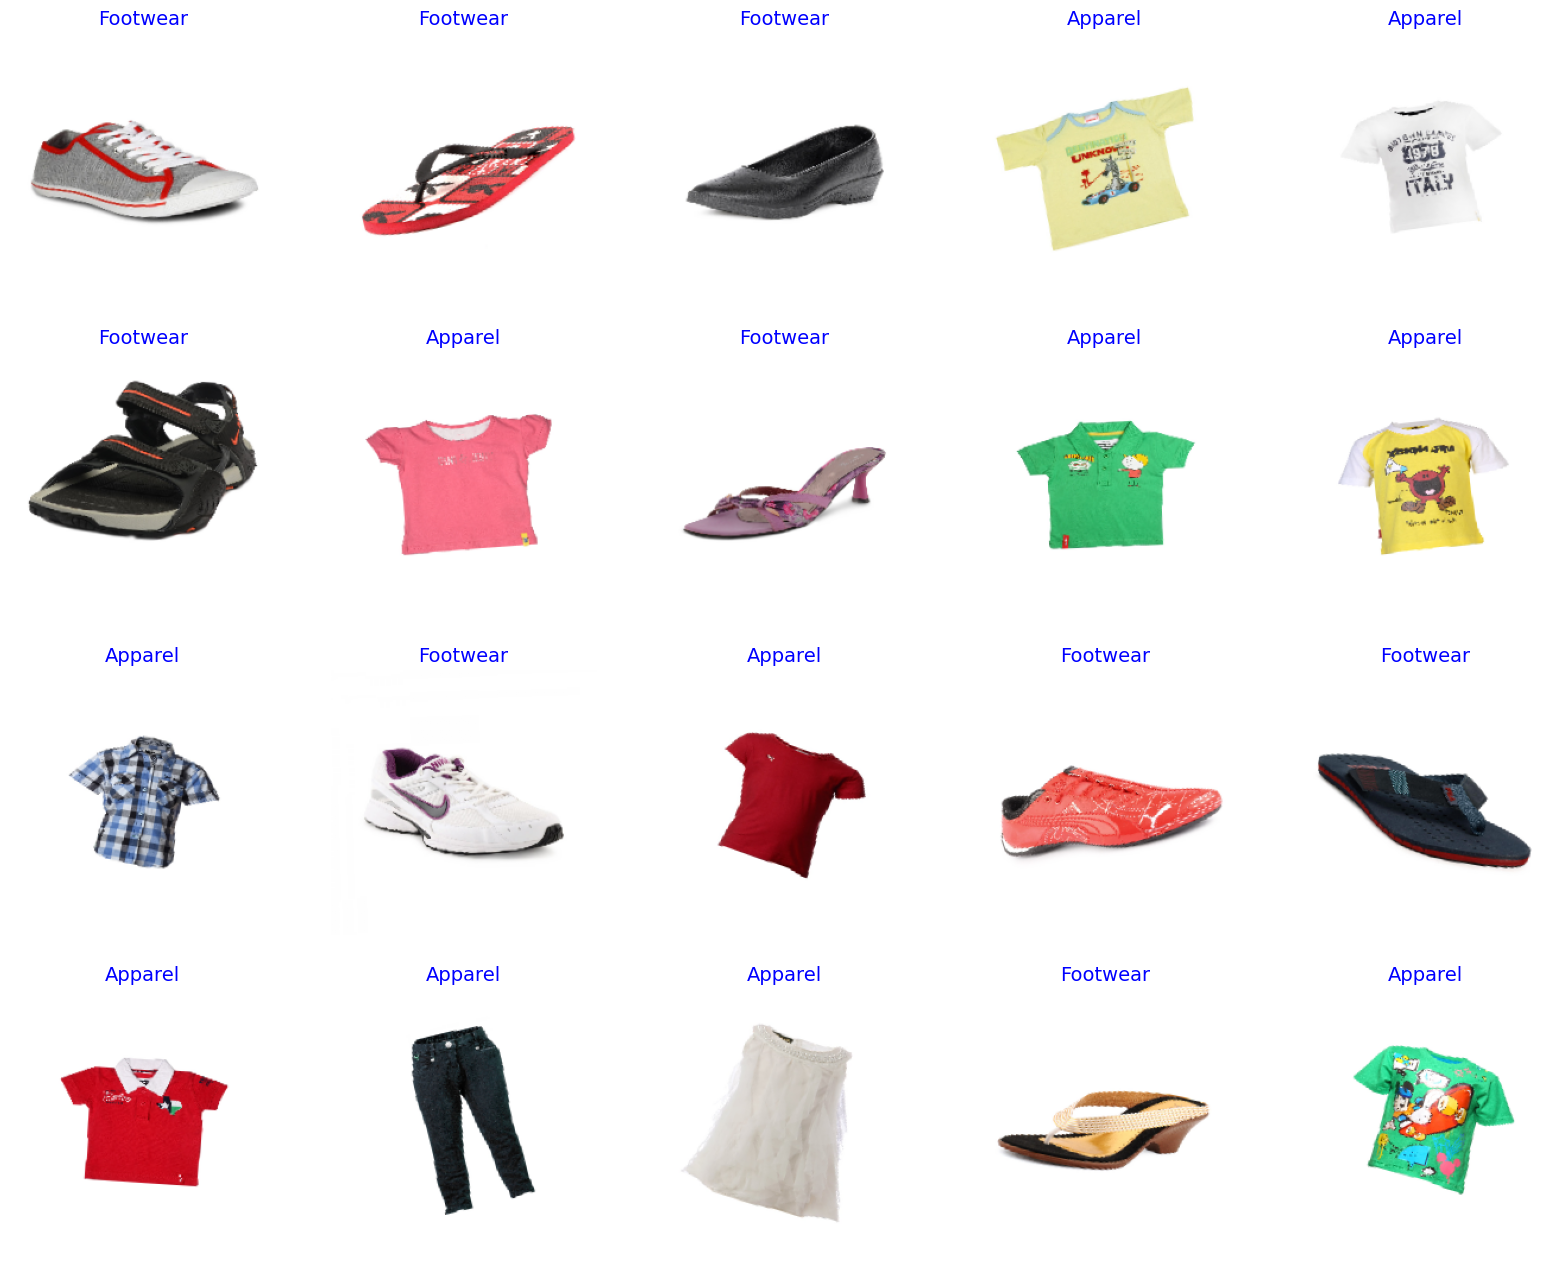

In [13]:
show_image_samples(train_gen)


#Model Building

In [14]:
img_shape = (img_size[0], img_size[1], 3)
model_name = 'MobileNet'
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
x = base_model.output
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
modell = Model(inputs=base_model.input, outputs=output)
lr = 0.01 # learning rate
modell.compile(Adamax(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
train_gen, valid_gen, test_gen = setup_data_generators(train_df, valid_df, test_df, img_size, batch_size=20)

epochs = 16
history = modell.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False, # as we already shuffeled it during creating the train_gen previously if you remember
    initial_epoch=0
)

Found 1815 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 100 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 90 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 576 validated image filenames belonging to 2 classes.
Test batch size: 72 Test steps: 8 Number of classes: 2
Epoch 1/16
91/91 [==============================] - 467s 5s/step - loss: 6.8421 - accuracy: 0.9146 - val_loss: 4.2862 - val_accuracy: 0.4078
Epoch 2/16
91/91 [==============================] - 92s 1s/step - loss: 2.4665 - accuracy: 0.9780 - val_loss: 3.2174 - val_accuracy: 0.4078
Epoch 3/16
91/91 [==============================] - 81s 892ms/step - loss: 1.3820 - accuracy: 0.9857 - val_loss: 1.7474 - val_accuracy: 0.5942
Epoch 4/16
91/91 [==============================] - 83s 907ms/step - loss: 0.8209 - accuracy: 0.9879 - val_loss: 2.2335 - val_accuracy: 0.4078
Epoch 5/16
91/91 [==============================] - 82s 902ms/step - loss: 0.5100 - accuracy: 0.9901 - val_loss: 2.3485 - val_accuracy: 0.4078
Epoch 6/16
91/91 [==============================] - 80s 882ms/step - loss: 0.3294 - accuracy: 0.9890 - val_loss: 2.5393 - val_accuracy: 0.4078
Epoch 7/16
91/91 [==============

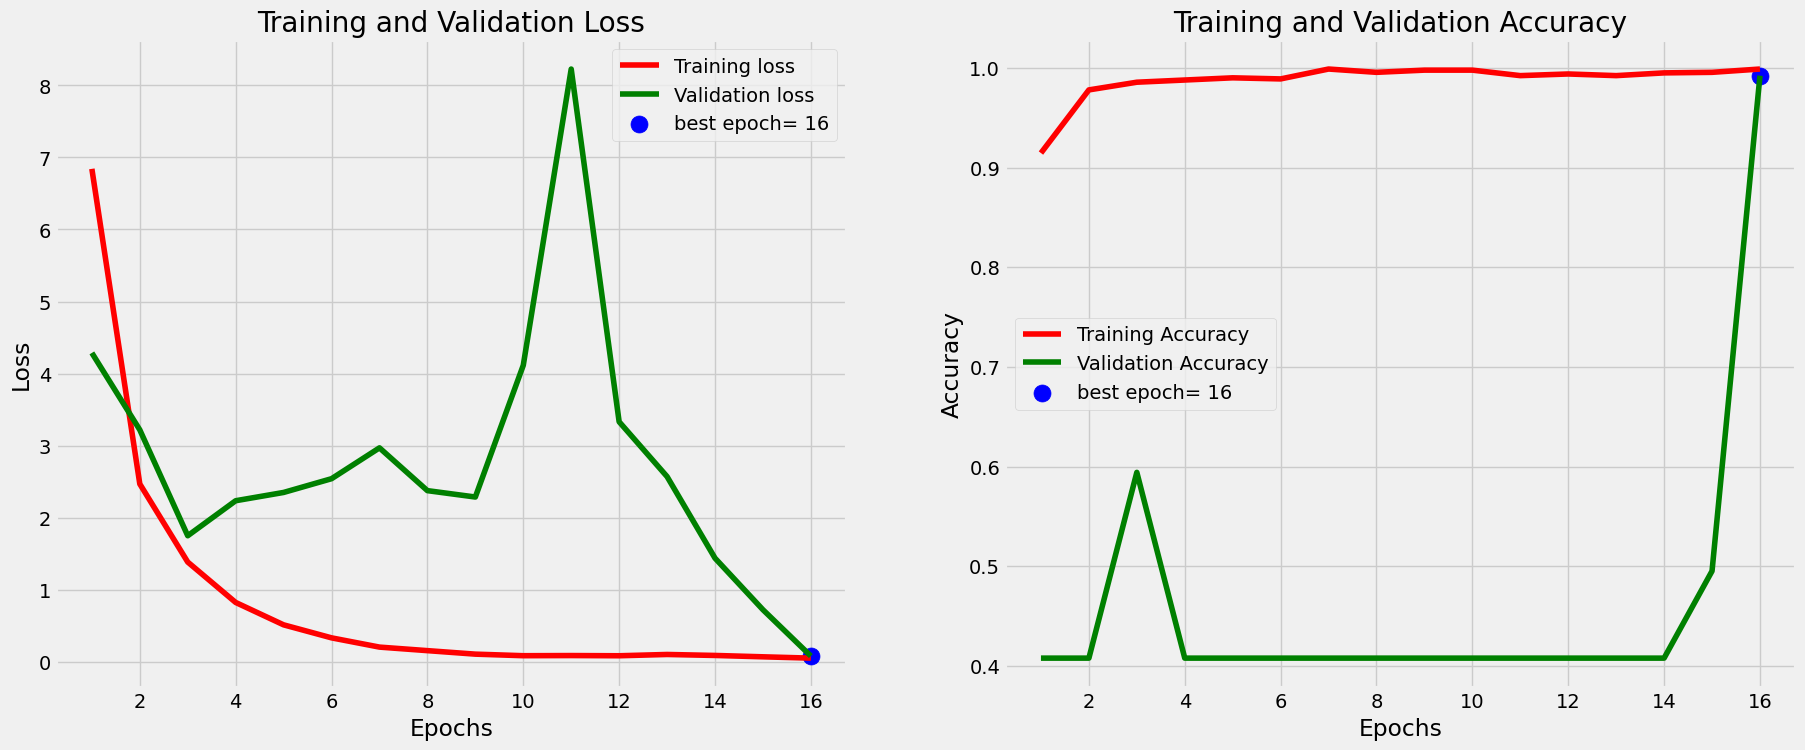

In [16]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()
tr_plot(history,0)

# Fine tuning

## Grid search

In [17]:
# # defining a function that builds the model to use it in the grid search loop to decide the best hyper-parameters we can use
# def build_model(learning_rate):
#     base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     base_model.trainable = True
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(256, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.4)(x)
#     output = Dense(1, activation='sigmoid')(x)

#     model = tf.keras.Model(inputs=base_model.input, outputs=output)
#     model.compile(optimizer=Adamax(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [18]:
# # we will use the grid search method to find the most suitable learnong rate and number of training epochs as both are hyper-parameters

# learning_rates = [0.001, 0.0001]
# num_epochs_list = [10, 15, 20, 25]

# best_val_accuracy = 0
# best_learning_rate = None
# best_num_epochs = None

# # Loop over learning rates and epochs
# for lr in learning_rates:
#     for num_epochs in num_epochs_list:
#         model = build_model(lr)
#         early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#         history = model.fit(train_gen, epochs=num_epochs, validation_data=valid_gen, callbacks=[early_stopping], verbose=1)
#         val_accuracy = model.evaluate(valid_gen, verbose=0)[1] # Evaluate model on validation set

#         # Print results
#         print(f"Learning rate: {lr}, Epochs: {num_epochs}, Validation accuracy: {val_accuracy}")

#         # Check if this combination improves validation accuracy
#         if val_accuracy > best_val_accuracy:
#             best_val_accuracy = val_accuracy
#             best_learning_rate = lr
#             best_num_epochs = num_epochs

# print(f"Best validation accuracy: {best_val_accuracy}")
# print(f"Best learning rate: {best_learning_rate}")
# print(f"Best number of epochs: {best_num_epochs}")

##Fine tuned MobileNetV2

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
img_shape = (img_size[0], img_size[1], 3)
model_name = 'MobileNet'
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
base_model.trainable = True # here we set the model to be trainable to learn new features from the images provided at training
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x) # we added batch normalization to make the calculation less complex thus reduce overfitting as possible and improve generalization
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.4, seed=123)(x)   # we added a dropout as a regularization technique to reduce overfitting as possible
output = Dense(1, activation='sigmoid')(x) # the activation function of the output layer  is sigmoid function as we are doing a binary classification
tuned_model = Model(inputs=base_model.input, outputs=output)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) # to reduce the unnecesssary training epochs in addition to prevention overfitting
tuned_model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
tuned_history=tuned_model.fit(x=train_gen,  epochs=20, verbose=1, validation_data=valid_gen,
                shuffle=False,  initial_epoch=0, callbacks = early_stopping)

Epoch 1/20
91/91 [==============================] - 102s 887ms/step - loss: 5.2615 - accuracy: 0.9769 - val_loss: 4.3632 - val_accuracy: 0.8078
Epoch 2/20
91/91 [==============================] - 105s 1s/step - loss: 2.7808 - accuracy: 0.9934 - val_loss: 2.5219 - val_accuracy: 0.9359
Epoch 3/20
91/91 [==============================] - 80s 881ms/step - loss: 1.7377 - accuracy: 0.9994 - val_loss: 1.6732 - val_accuracy: 0.9087
Epoch 4/20
91/91 [==============================] - 91s 1000ms/step - loss: 1.1672 - accuracy: 0.9972 - val_loss: 1.1760 - val_accuracy: 0.9146
Epoch 5/20
91/91 [==============================] - 82s 902ms/step - loss: 0.8106 - accuracy: 0.9983 - val_loss: 0.8519 - val_accuracy: 0.9553
Epoch 6/20
91/91 [==============================] - 89s 975ms/step - loss: 0.5860 - accuracy: 0.9972 - val_loss: 0.5870 - val_accuracy: 0.9825
Epoch 7/20
91/91 [==============================] - 84s 924ms/step - loss: 0.4452 - accuracy: 0.9950 - val_loss: 0.4021 - val_accuracy: 0.9981

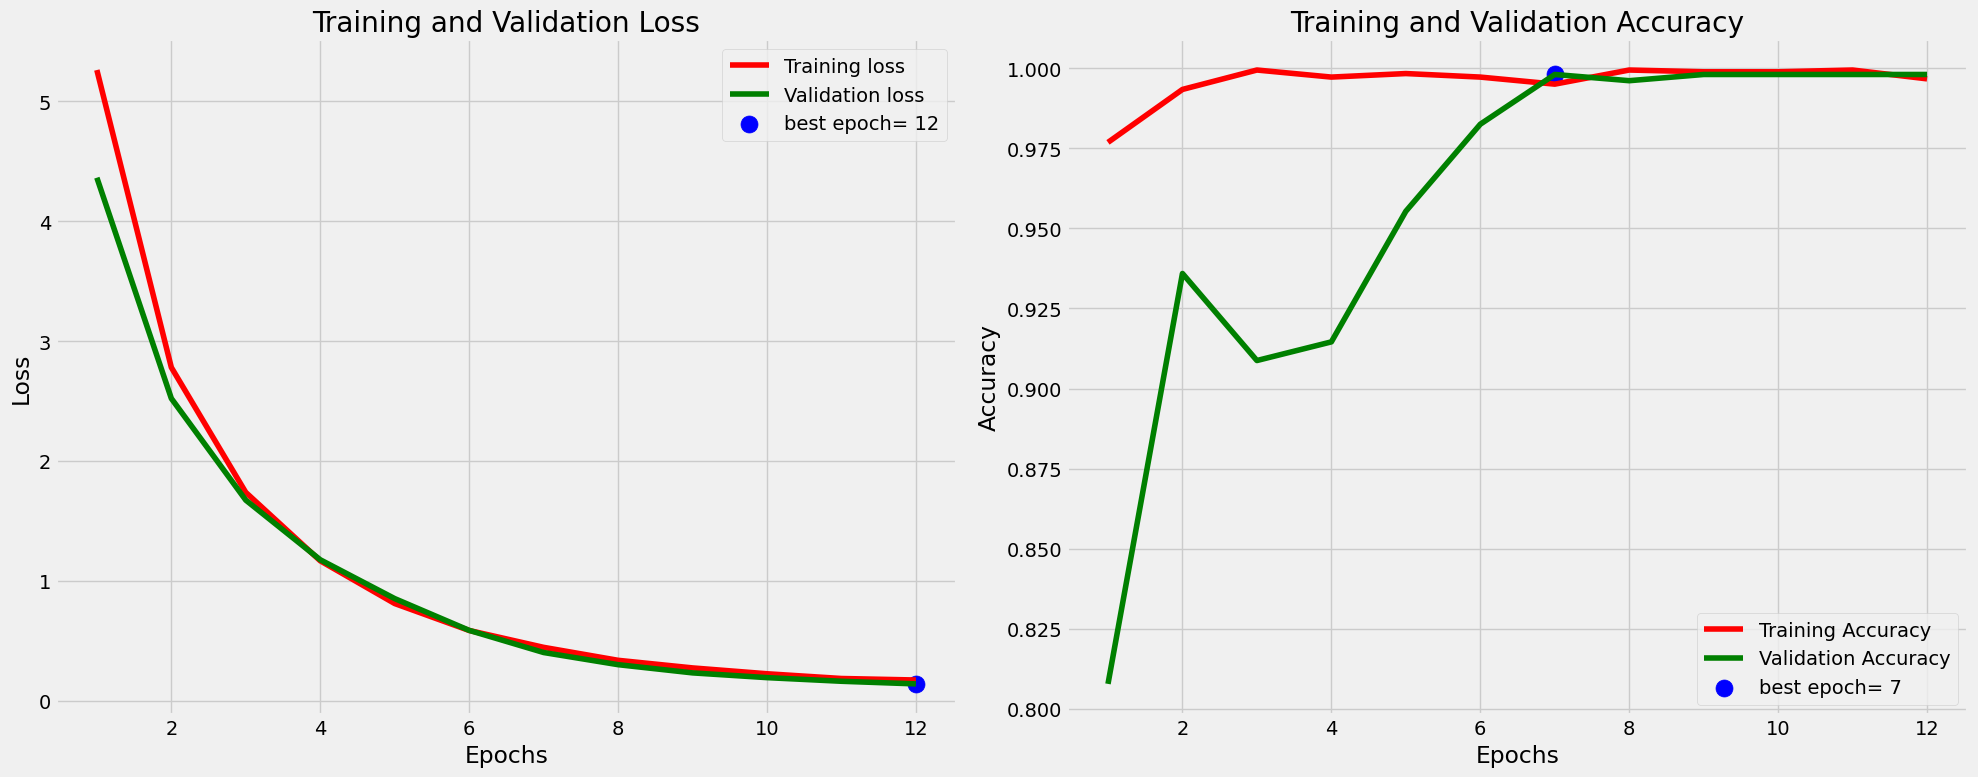

In [24]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    plt.show()
tr_plot(tuned_history,0)

## comparing both regular and fine tuned models

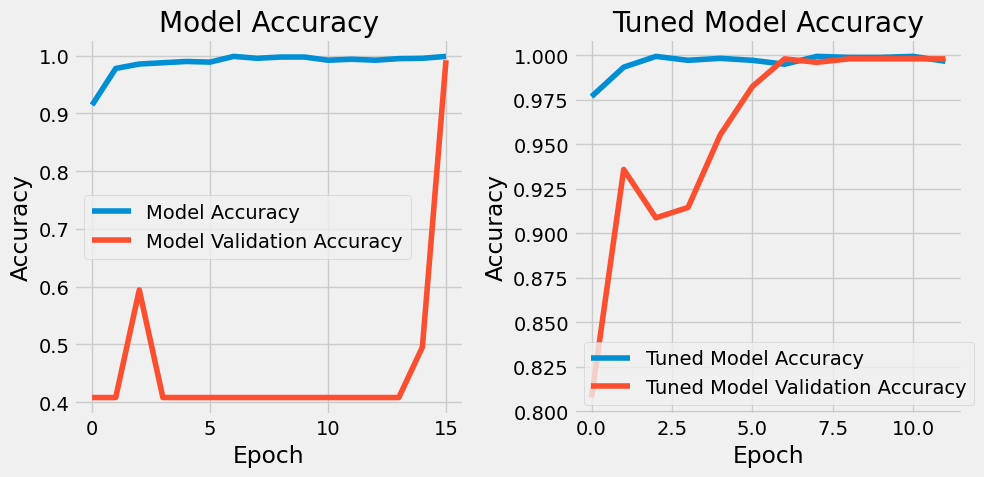

In [25]:
# Plot training and validation accuracy for the first model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model Accuracy')
plt.plot(history.history['val_accuracy'], label='Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot training and validation accuracy for the second model
plt.subplot(1, 2, 2)
plt.plot(tuned_history.history['accuracy'], label='Tuned Model Accuracy')
plt.plot(tuned_history.history['val_accuracy'], label='Tuned Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Tuned Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# model testing

In [26]:
def predictor(model, test_gen, test_steps):
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())

    # Make predictions on the test data
    y_pred_probs = model.predict(test_gen, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100
    print(f'Test Accuracy: {accuracy:.2f}')

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', xticks_rotation='vertical')

    # Generate classification report
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return accuracy

## testing the regular model

In [ ]:
test_steps = len(test_gen)
accuracy = predictor(modell, test_gen, test_steps)

2/8 [======>.......................] - ETA: 1:54

##testing the fine_tuned model

In [ ]:
accuracy = predictor(tuned_model, test_gen, test_steps)

# Saving the  models

In [ ]:
save_id= 'regular_model.h5'
model_save_loc1=os.path.join(working_dir, save_id)
modell.save(model_save_loc1)
print ('model was saved as ' , model_save_loc1)

In [ ]:
save_id= 'fine_tuned_model.h5'
model_save_loc2=os.path.join(working_dir, save_id)
tuned_model.save(model_save_loc2)
print ('model was saved as ' , model_save_loc2)